In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu118
0.16.0+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [5]:
import os
import zipfile 

from pathlib import Path
import requests

# example source: https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
  """Downloads a zipped dataset from source and unzips to destination."""
  # Setup path to data folder
  data_path = Path("data/")
  image_path = data_path /destination

  # If the image folder doesn't exist, create it
  if image_path.is_dir():
    print(f"[INFO] {image_path} directory already exists, skipping download.")
  else:
    print(f"[INFO] Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download the target data
    target_file = Path(source).name
    with open(data_path / target_file, "wb") as f:
      request = requests.get(source) 
      print(f"[INFO] Downloading {target_file} from {source}...")
      f.write(request.content)
    
    # Unzip target file
    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
      print(f"[INFO] Unzipping {target_file} data...")
      zip_ref.extractall(image_path)
    
    # Remove .zip file if needed
    if remove_source:
      os.remove(data_path / target_file)
  
  return image_path
     

In [6]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str = None):
  """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance tracking to a specific directory."""
  from datetime import datetime
  import os

  # Get timestamp of current date in reverse order
  timestamp = datetime.now().strftime("%Y-%m-%d") 

  if extra:
    # Create log directory path
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
  else:
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
  print(f"[INFO] Created SummaryWriter saving to {log_dir}")
  return SummaryWriter(log_dir=log_dir)

In [7]:

# Download 10 percent and 20 percent datasets
data_10_percent_path = download_data(source="https://github.com/CarlosGaubertQ/dataset-eurosat-9-1/raw/main/EUROSAT.zip",
                                     destination="EUROSAT_10")

data_20_percent_path = download_data(source="https://github.com/CarlosGaubertQ/dataset-eurosat-8-2/raw/main/EUROSAT.zip",
                                     destination="EUROSAT_20")

[INFO] data\EUROSAT_10 directory already exists, skipping download.
[INFO] data\EUROSAT_20 directory already exists, skipping download.


In [8]:

# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup the test directory
test_dir = data_10_percent_path / "test"

train_dir_10_percent, train_dir_20_percent, test_dir

(WindowsPath('data/EUROSAT_10/train'),
 WindowsPath('data/EUROSAT_20/train'),
 WindowsPath('data/EUROSAT_10/test'))

In [9]:
from torchvision import transforms

# Setup ImageNet normalization levels
# See here: https://pytorch.org/vision/0.12/models.html 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Compose transforms into a pipleine
simple_transform = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       normalize
])
     

In [10]:
BATCH_SIZE = 32
from going_modular.going_modular import data_setup, engine
# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

# Create 20% training and test DataLoaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

print(f"Number of batches of size {BATCH_SIZE} in 10% train data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20% train data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 10% test data: {len(test_dataloader)}")
print(f"Class names: {class_names}")

Number of batches of size 32 in 10% train data: 760
Number of batches of size 32 in 20% train data: 675
Number of batches of size 32 in 10% test data: 85
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [12]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

# Create an EffNetB0 feature extractor
def create_effnetb0():
  # Get the weights and setup a model
  weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
  model = torchvision.models.efficientnet_b0(weights=weights).to(device)
  transforms = weights.transforms()
  # Freeze the base model layers
  for param in model.features.parameters():
    param.requires_grad = False

  # Change the classifier head
  set_seeds()
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.2, inplace=True),
      nn.Linear(in_features=1280, out_features=OUT_FEATURES)
  ).to(device)

  # Give the model a name
  model.name = "effnetb0"
  print(f"[INFO] Created new {model.name} model...")
  return model, transforms

# Create an EffNetB2 feature extractor
def create_effnetb2():
  # Get the weights and setup a model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  model = torchvision.models.efficientnet_b2(weights=weights).to(device)
  transforms = weights.transforms()
  # Freeze the base model layers
  for param in model.features.parameters():
    param.requires_grad = False

  # Change the classifier head
  set_seeds()
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=OUT_FEATURES)
  ).to(device)

  # Give the model a name
  model.name = "effnetb2"
  print(f"[INFO] Created new {model.name} model...")
  return model, transforms

In [14]:
created_model_test_effnetb2, created_model_test_effnetb2_transforms = create_effnetb2()
created_model_test_effnetb0, created_model_test_effnetb0_transforms = create_effnetb0()
created_model_test_effnetb2_transforms

[INFO] Created new effnetb2 model...
[INFO] Created new effnetb0 model...


ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [15]:
# Create epoch list
num_epochs = [5, 10]

# Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"] 

# Create a DataLoaders dictionary
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [16]:


# Setup a SummaryWriter
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer

In [17]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

from going_modular.going_modular.engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        if writer: 
          # See SummaryWriter documentation
          writer.add_scalars(main_tag="Loss",
                              tag_scalar_dict={"train_loss": train_loss,
                                              "test_loss": test_loss},
                              global_step=epoch)
          
          writer.add_scalars(main_tag="Accuracy",
                              tag_scalar_dict={"train_acc": train_acc,
                                              "test_acc": test_acc},
                              global_step=epoch)
          
          writer.add_graph(model=model,
                            input_to_model=torch.randn(32, 3, 224, 224).to(device))

          # Close the writer
          writer.close()
        
        else:
          pass
    ### End new ### 

    # Return the filled results at the end of the epochs
    return results

In [19]:
for dataloader_name, train_dataloader in train_dataloaders.items():
  print(dataloader_name)

data_10_percent
data_20_percent


In [23]:
%%time
from going_modular.going_modular.utils import save_model


# Set seeds
set_seeds(seed=42)

# Keep track of experiment numbers
experiment_number = 0

# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
  # Loop through the epochs
  for epochs in num_epochs:
    # Loop through each model name and create a new model instance
    for model_name in models:

      # Print out info
      experiment_number += 1
      print(f"[INFO] Experiment number: {experiment_number}")
      print(f"[INFO] Model: {model_name}")
      print(f"[INFO] DataLoader: {dataloader_name}")
      print(f"[INFO] Number of epochs: {epochs}")

      # Select and create the model
      if model_name == "effnetb0":
        model = create_effnetb0()
      elif( model_name == "effnetb2"):
        model = create_effnetb2()
      
      # Create a new loss and optimizer for every model
      loss_fn = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

      # Train target model with target dataloader and track experiments 
      # Note: using train() rather than engine.train()
      train(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=epochs,
            device=device,
            writer=create_writer(experiment_name=dataloader_name,
                                 model_name=model_name,
                                 extra=f"{epochs}_epochs"))
      
      # Save the model to file so we can import it later if need be
      save_filepath = f"CNN_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
      save_model(model=model,
                 target_dir="models/CNN_experiment_tracking/",
                 model_name=save_filepath)
      print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter saving to runs\2023-11-04\data_10_percent\effnetb0\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5481 | train_acc: 0.8392 | test_loss: 0.2624 | test_acc: 0.9134
Epoch: 2 | train_loss: 0.3400 | train_acc: 0.8865 | test_loss: 0.2370 | test_acc: 0.9192
Epoch: 3 | train_loss: 0.3149 | train_acc: 0.8924 | test_loss: 0.2164 | test_acc: 0.9283
Epoch: 4 | train_loss: 0.3047 | train_acc: 0.8972 | test_loss: 0.2132 | test_acc: 0.9270
Epoch: 5 | train_loss: 0.2926 | train_acc: 0.8993 | test_loss: 0.2009 | test_acc: 0.9283
[INFO] Saving model to: models\07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter saving to runs\2023-11-04\data_10_percent\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6163 | train_acc: 0.8227 | test_loss: 0.3201 | test_acc: 0.9012
Epoch: 2 | train_loss: 0.3958 | train_acc: 0.8718 | test_loss: 0.2734 | test_acc: 0.9075
Epoch: 3 | train_loss: 0.3643 | train_acc: 0.8777 | test_loss: 0.2497 | test_acc: 0.9119
Epoch: 4 | train_loss: 0.3565 | train_acc: 0.8812 | test_loss: 0.2460 | test_acc: 0.9112
Epoch: 5 | train_loss: 0.3542 | train_acc: 0.8809 | test_loss: 0.2326 | test_acc: 0.9152
[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter saving to runs\2023-11-04\data_10_percent\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5481 | train_acc: 0.8392 | test_loss: 0.2624 | test_acc: 0.9134
Epoch: 2 | train_loss: 0.3400 | train_acc: 0.8865 | test_loss: 0.2370 | test_acc: 0.9192
Epoch: 3 | train_loss: 0.3149 | train_acc: 0.8924 | test_loss: 0.2164 | test_acc: 0.9283
Epoch: 4 | train_loss: 0.3047 | train_acc: 0.8972 | test_loss: 0.2132 | test_acc: 0.9270
Epoch: 5 | train_loss: 0.2926 | train_acc: 0.8993 | test_loss: 0.2009 | test_acc: 0.9283
Epoch: 6 | train_loss: 0.2881 | train_acc: 0.9027 | test_loss: 0.2000 | test_acc: 0.9306
Epoch: 7 | train_loss: 0.2804 | train_acc: 0.9038 | test_loss: 0.1931 | test_acc: 0.9342
Epoch: 8 | train_loss: 0.2784 | train_acc: 0.9034 | test_loss: 0.2035 | test_acc: 0.9324
Epoch: 9 | train_loss: 0.2782 | train_acc: 0.9021 | test_loss: 0.1909 | test_acc: 0.9375
Epoch: 10 | train_loss: 0.2736 | train_acc: 0.9063 | test_loss: 0.1942 | test_acc: 0.9360
[INFO] Saving model to: models\07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6163 | train_acc: 0.8227 | test_loss: 0.3201 | test_acc: 0.9012
Epoch: 2 | train_loss: 0.3958 | train_acc: 0.8718 | test_loss: 0.2734 | test_acc: 0.9075
Epoch: 3 | train_loss: 0.3643 | train_acc: 0.8777 | test_loss: 0.2497 | test_acc: 0.9119
Epoch: 4 | train_loss: 0.3565 | train_acc: 0.8812 | test_loss: 0.2460 | test_acc: 0.9112
Epoch: 5 | train_loss: 0.3542 | train_acc: 0.8809 | test_loss: 0.2326 | test_acc: 0.9152
Epoch: 6 | train_loss: 0.3336 | train_acc: 0.8861 | test_loss: 0.2362 | test_acc: 0.9148
Epoch: 7 | train_loss: 0.3421 | train_acc: 0.8813 | test_loss: 0.2357 | test_acc: 0.9200
Epoch: 8 | train_loss: 0.3361 | train_acc: 0.8857 | test_loss: 0.2372 | test_acc: 0.9145
Epoch: 9 | train_loss: 0.3460 | train_acc: 0.8836 | test_loss: 0.2303 | test_acc: 0.9187
Epoch: 10 | train_loss: 0.3324 | train_acc: 0.8863 | test_loss: 0.2237 | test_acc: 0.9191
[INFO] Saving model to: models\07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5702 | train_acc: 0.8309 | test_loss: 0.2741 | test_acc: 0.9152
Epoch: 2 | train_loss: 0.3514 | train_acc: 0.8825 | test_loss: 0.2413 | test_acc: 0.9228
Epoch: 3 | train_loss: 0.3184 | train_acc: 0.8932 | test_loss: 0.2203 | test_acc: 0.9259
Epoch: 4 | train_loss: 0.3003 | train_acc: 0.8978 | test_loss: 0.2135 | test_acc: 0.9283
Epoch: 5 | train_loss: 0.2927 | train_acc: 0.8987 | test_loss: 0.2084 | test_acc: 0.9324
[INFO] Saving model to: models\07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter saving to runs\2023-11-04\data_20_percent\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6294 | train_acc: 0.8240 | test_loss: 0.3317 | test_acc: 0.8946
Epoch: 2 | train_loss: 0.3991 | train_acc: 0.8688 | test_loss: 0.2808 | test_acc: 0.9086
Epoch: 3 | train_loss: 0.3713 | train_acc: 0.8770 | test_loss: 0.2616 | test_acc: 0.9134
Epoch: 4 | train_loss: 0.3540 | train_acc: 0.8809 | test_loss: 0.2592 | test_acc: 0.9100
Epoch: 5 | train_loss: 0.3430 | train_acc: 0.8842 | test_loss: 0.2428 | test_acc: 0.9159
[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter saving to runs\2023-11-04\data_20_percent\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5702 | train_acc: 0.8309 | test_loss: 0.2741 | test_acc: 0.9152
Epoch: 2 | train_loss: 0.3514 | train_acc: 0.8825 | test_loss: 0.2413 | test_acc: 0.9228
Epoch: 3 | train_loss: 0.3184 | train_acc: 0.8932 | test_loss: 0.2203 | test_acc: 0.9259
Epoch: 4 | train_loss: 0.3003 | train_acc: 0.8978 | test_loss: 0.2135 | test_acc: 0.9283
Epoch: 5 | train_loss: 0.2927 | train_acc: 0.8987 | test_loss: 0.2084 | test_acc: 0.9324
Epoch: 6 | train_loss: 0.2873 | train_acc: 0.8991 | test_loss: 0.2096 | test_acc: 0.9279
Epoch: 7 | train_loss: 0.2746 | train_acc: 0.9049 | test_loss: 0.1923 | test_acc: 0.9339
Epoch: 8 | train_loss: 0.2753 | train_acc: 0.9035 | test_loss: 0.2068 | test_acc: 0.9316
Epoch: 9 | train_loss: 0.2661 | train_acc: 0.9080 | test_loss: 0.2051 | test_acc: 0.9266
Epoch: 10 | train_loss: 0.2653 | train_acc: 0.9075 | test_loss: 0.1993 | test_acc: 0.9313
[INFO] Saving model to: models\07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6294 | train_acc: 0.8240 | test_loss: 0.3317 | test_acc: 0.8946
Epoch: 2 | train_loss: 0.3991 | train_acc: 0.8688 | test_loss: 0.2808 | test_acc: 0.9086
Epoch: 3 | train_loss: 0.3713 | train_acc: 0.8770 | test_loss: 0.2616 | test_acc: 0.9134
Epoch: 4 | train_loss: 0.3540 | train_acc: 0.8809 | test_loss: 0.2592 | test_acc: 0.9100
Epoch: 5 | train_loss: 0.3430 | train_acc: 0.8842 | test_loss: 0.2428 | test_acc: 0.9159
Epoch: 6 | train_loss: 0.3480 | train_acc: 0.8831 | test_loss: 0.2472 | test_acc: 0.9130
Epoch: 7 | train_loss: 0.3431 | train_acc: 0.8833 | test_loss: 0.2306 | test_acc: 0.9218
Epoch: 8 | train_loss: 0.3327 | train_acc: 0.8844 | test_loss: 0.2342 | test_acc: 0.9181
Epoch: 9 | train_loss: 0.3269 | train_acc: 0.8868 | test_loss: 0.2264 | test_acc: 0.9225
Epoch: 10 | train_loss: 0.3350 | train_acc: 0.8876 | test_loss: 0.2433 | test_acc: 0.9148
[INFO] Saving model to: models\07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

In [3]:
# Let's view our experiments within TensorBoard from within the notebook
%load_ext tensorboard
%tensorboard --logdir runs 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 531824), started 1 day, 21:05:55 ago. (Use '!kill 531824' to kill it.)

In [12]:

# Setup best model filepath
best_model_path = "models/07_effnetb0_data_10_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load in the saved state_dict())
best_model = create_effnetb0()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb0 model...


<All keys matched successfully>

In [13]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert it to megabytes
effnetb0_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb0_model_size} MB")

EfficientNetB2 feature extractor model size: 15 MB


CPU times: total: 3.69 s
Wall time: 638 ms


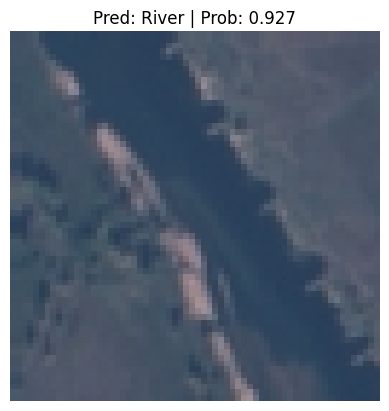

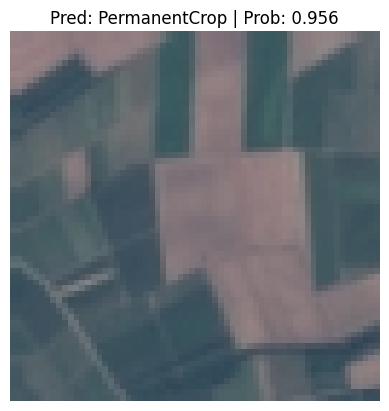

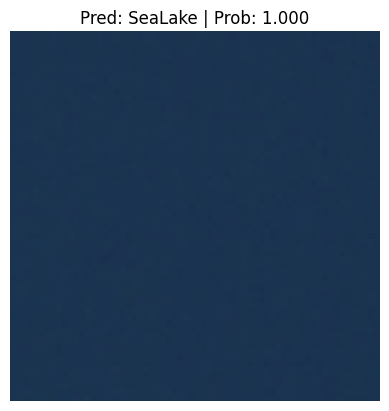

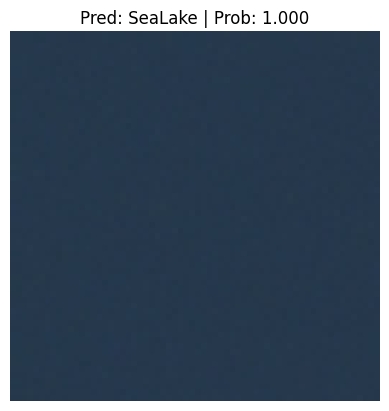

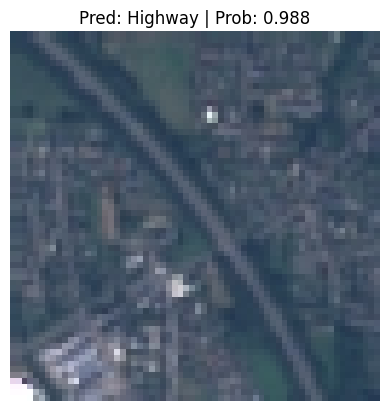

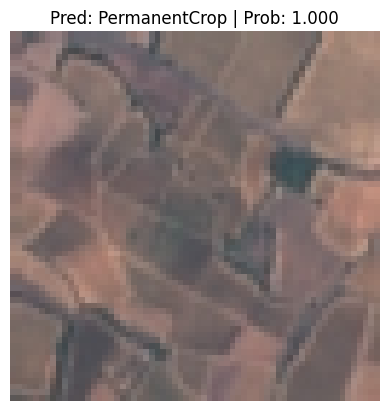

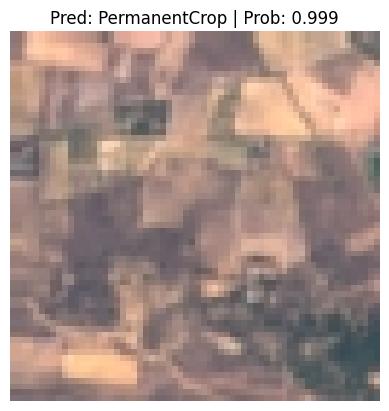

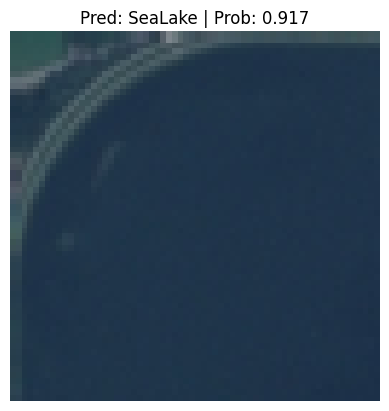

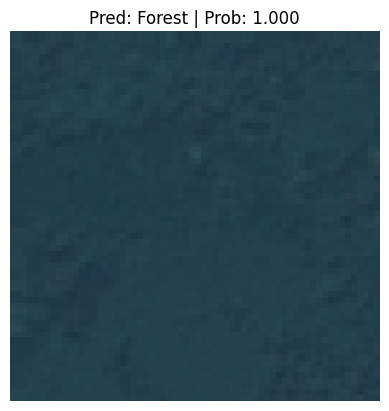

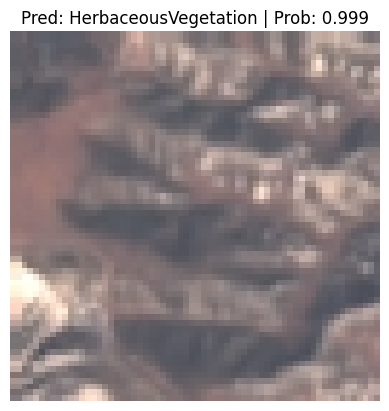

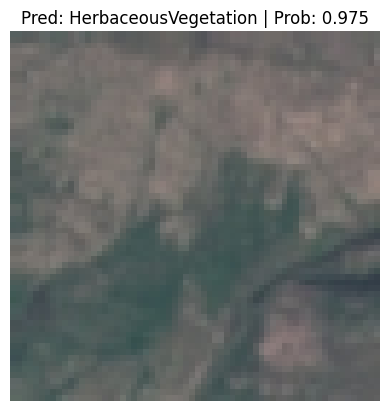

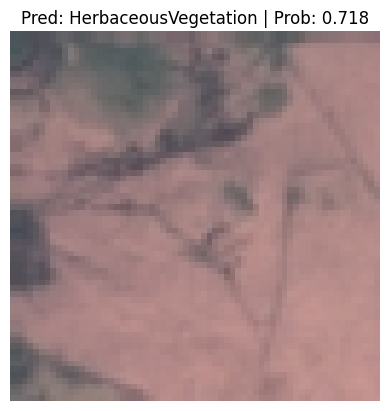

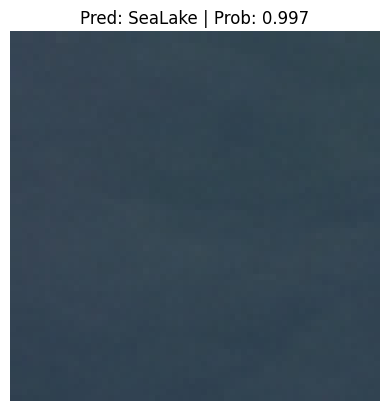

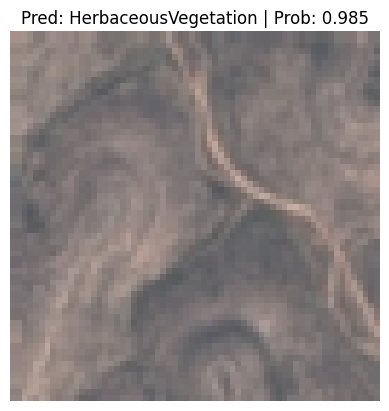

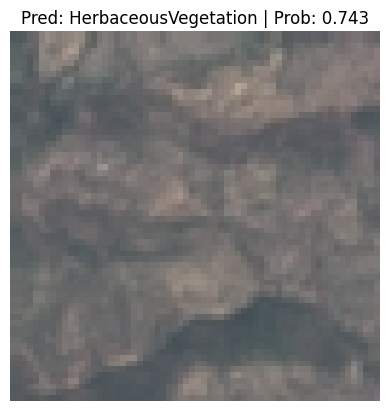

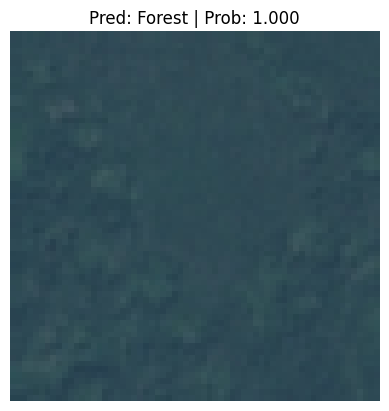

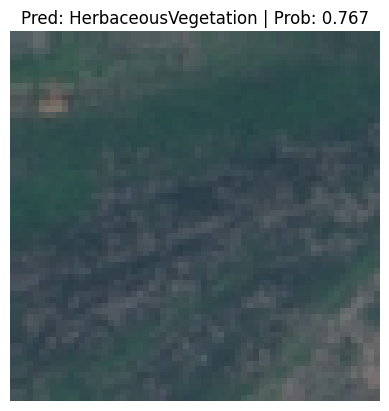

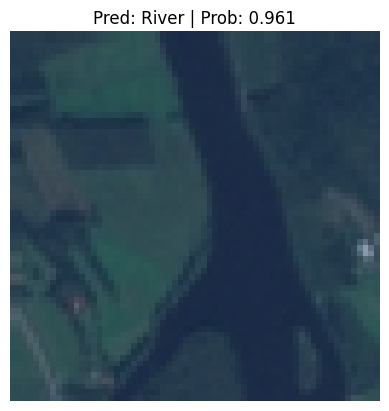

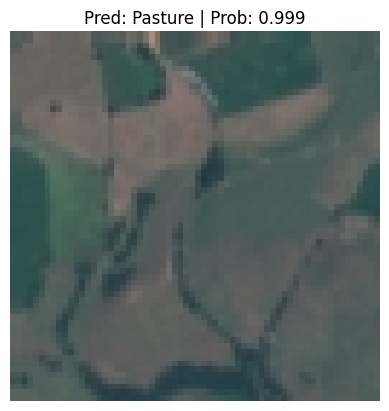

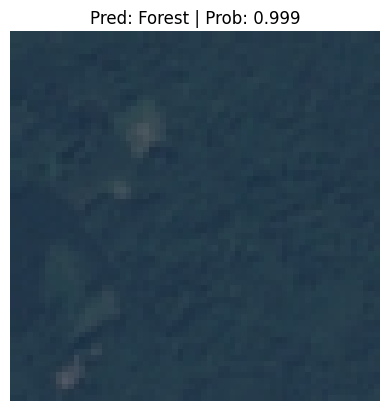

In [15]:
%%time
# Import function to make prediction on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Get a random list of 3 image path names from the test dataset
import random
num_images_to_plot = 20
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list,
                                       k=num_images_to_plot)

for image_path in test_image_path_sample:
  pred_and_plot_image(model=best_model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))